In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/wind-speed-prediction-dataset/wind_dataset.csv


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings(action='ignore')

import datetime

from sklearn.metrics import mean_absolute_error

from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

In [3]:
df=pd.read_csv('wind_dataset.csv')

In [4]:
df.head()

,DATE,WIND,IND,RAIN,IND.1,T.MAX,IND.2,T.MIN,T.MIN.G
0,1961-01-01,13.67,0,0.2,0.0,9.5,0.0,3.7,-1.0
1,1961-01-02,11.50,0,5.1,0.0,7.2,0.0,4.2,1.1
2,1961-01-03,11.25,0,0.4,0.0,5.5,0.0,0.5,-0.5
3,1961-01-04,8.63,0,0.2,0.0,5.6,0.0,0.4,-3.2
4,1961-01-05,11.92,0,10.4,0.0,7.2,1.0,-1.5,-7.5


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6574 entries, 0 to 6573
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   DATE     6574 non-null   object 
 1   WIND     6574 non-null   float64
 2   IND      6574 non-null   int64  
 3   RAIN     6574 non-null   float64
 4   IND.1    6513 non-null   float64
 5   T.MAX    5953 non-null   float64
 6   IND.2    6513 non-null   float64
 7   T.MIN    5900 non-null   float64
 8   T.MIN.G  6214 non-null   float64
dtypes: float64(7), int64(1), object(1)
memory usage: 462.4+ KB


In [6]:
df['DATE']=pd.to_datetime(df['DATE'])

# Visalization

* Time Series Plot by Wind

<AxesSubplot:xlabel='DATE'>

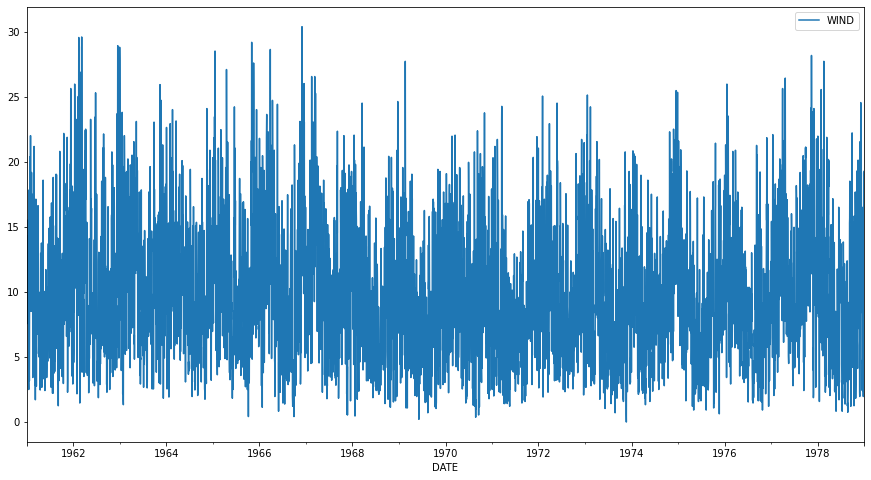

In [7]:
df.plot(x='DATE',y='WIND',figsize=(15,8))

* Correlation among the features

<AxesSubplot:>

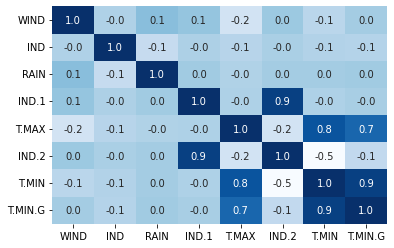

In [8]:
sns.heatmap(df.corr(),annot=True, cbar=False, cmap='Blues', fmt='.1f')

* Boxplot: 'WIND'

<AxesSubplot:xlabel='WIND'>

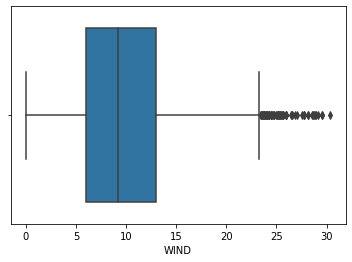

In [9]:
sns.boxplot(df['WIND'])

* Boxplot:'RAIN'

<AxesSubplot:xlabel='RAIN'>

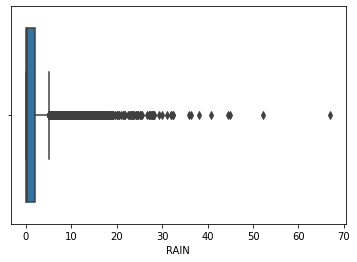

In [10]:
sns.boxplot(df['RAIN'])

* Boxplot:'Max Temperature'

<AxesSubplot:xlabel='T.MAX'>

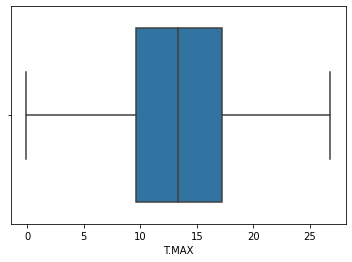

In [11]:
sns.boxplot(df['T.MAX'])

* Boxplot:'Minumum Temperature'

<AxesSubplot:xlabel='T.MIN'>

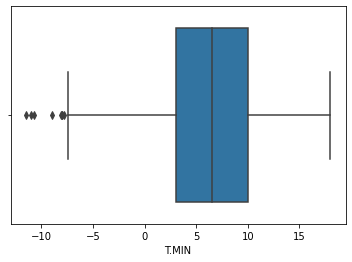

In [12]:
sns.boxplot(df['T.MIN'])

* Boxplot:'Minumum Grass Temperature'

<AxesSubplot:xlabel='T.MIN.G'>

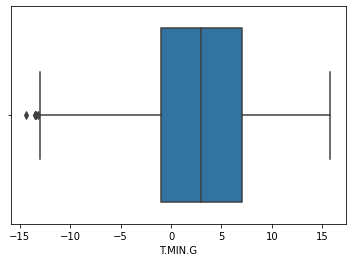

In [13]:
sns.boxplot(df['T.MIN.G'])

* Boxplot: First indicator value

<AxesSubplot:xlabel='IND', ylabel='Count'>

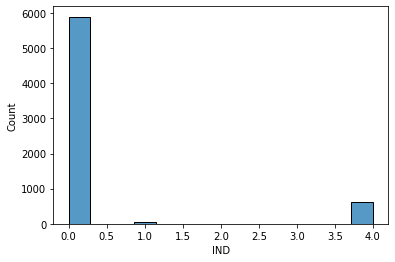

In [14]:
sns.histplot(df['IND'])

* Boxplot: Second indicator value

<AxesSubplot:xlabel='IND.1', ylabel='Count'>

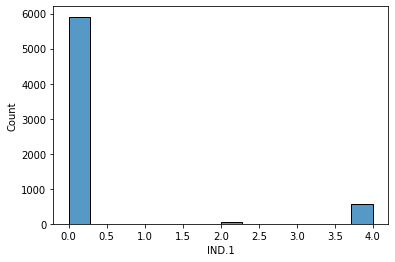

In [15]:
sns.histplot(df['IND.1'])

* Boxplot: Third indicator value

<AxesSubplot:xlabel='IND.2', ylabel='Count'>

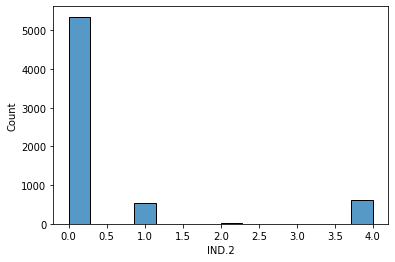

In [16]:
sns.histplot(df['IND.2'])

In [17]:
df = df.set_index('DATE')

* Time series of all features

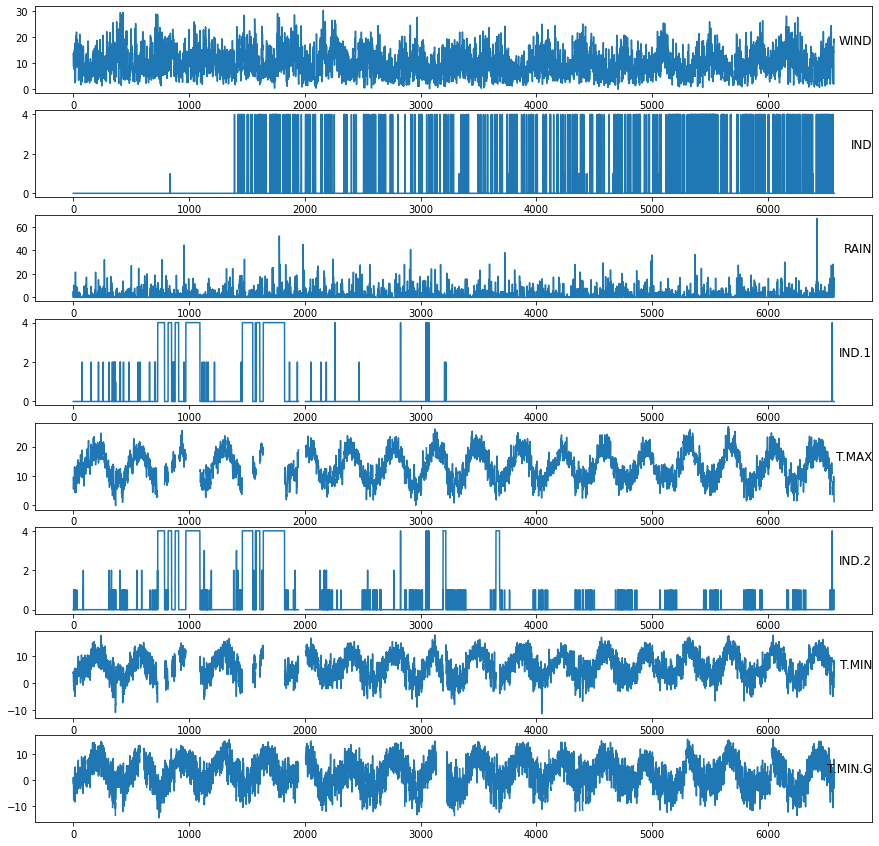

In [18]:
from matplotlib import pyplot
# load dataset
values = df.values
# specify columns to plot
groups = [0, 1, 2, 3,4, 5, 6, 7]
i = 1
# plot each column
pyplot.figure(figsize=(15,15))
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group])
    pyplot.title(df.columns[group], y=0.5, loc='right')
    i += 1
pyplot.show()

In [19]:
df=df.fillna(0)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6574 entries, 1961-01-01 to 1978-12-31
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   WIND     6574 non-null   float64
 1   IND      6574 non-null   int64  
 2   RAIN     6574 non-null   float64
 3   IND.1    6574 non-null   float64
 4   T.MAX    6574 non-null   float64
 5   IND.2    6574 non-null   float64
 6   T.MIN    6574 non-null   float64
 7   T.MIN.G  6574 non-null   float64
dtypes: float64(7), int64(1)
memory usage: 462.2 KB


* The number of instances is 6,574. I will split the dataset into train and test data in a 70% and 30% ratio of the instances.

In [20]:
6574*0.7

4601.799999999999

* Train – Test Split

In [21]:
train_df,test_df = df[1:4601], df[4601:] 

* Scaling the values

In [22]:
train = train_df
scalers={}
for i in train_df.columns:
    scaler = MinMaxScaler(feature_range=(-1,1))
    s_s = scaler.fit_transform(train[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+ i] = scaler
    train[i]=s_s
test = test_df
for i in train_df.columns:
    scaler = scalers['scaler_'+i]
    s_s = scaler.transform(test[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+i] = scaler
    test[i]=s_s

* Converting the series to samples 

Now I will make a function that will use a sliding window approach to transform our series into samples of input past observations and output future observations to use supervised learning algorithms.

In [23]:
def split_series(series, n_past, n_future):
  
  X, y = list(), list()
  for window_start in range(len(series)):
    past_end = window_start + n_past
    future_end = past_end + n_future
    if future_end > len(series):
      break
    past, future = series[window_start:past_end, :], series[past_end:future_end, :]
    X.append(past)
    y.append(future)
  return np.array(X), np.array(y)

For this case, let’s assume that given the past 10 days observation, we need to forecast the next 5 days observations.

In [24]:
n_past = 10
n_future = 5 
n_features = 8

* Convert both the train and test data into samples using the split_series function.

In [25]:
X_train, y_train = split_series(train.values,n_past, n_future)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))
X_test, y_test = split_series(test.values,n_past, n_future)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))

# Modeling

E1D1 ==> Sequence to Sequence Model with one encoder layer and one decoder layer.

In [26]:
# E1D1

encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder_l1 = tf.keras.layers.LSTM(100, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)

encoder_states1 = encoder_outputs1[1:]

decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs1[0])

decoder_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_outputs1 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l1)

model_e1d1 = tf.keras.models.Model(encoder_inputs,decoder_outputs1)

model_e1d1.summary()

2022-10-22 07:08:59.908623: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 10, 8)]      0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 100), (None, 43600       input_1[0][0]                    
__________________________________________________________________________________________________
repeat_vector (RepeatVector)    (None, 5, 100)       0           lstm[0][0]                       
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 5, 100)       80400       repeat_vector[0][0]              
                                                                 lstm[0][1]                   

E2D2 ==> Sequence to Sequence Model with two encoder layers and two decoder layers.

In [27]:
# E2D2

encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder_l1 = tf.keras.layers.LSTM(100,return_sequences = True, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)
encoder_states1 = encoder_outputs1[1:]
encoder_l2 = tf.keras.layers.LSTM(100, return_state=True)
encoder_outputs2 = encoder_l2(encoder_outputs1[0])
encoder_states2 = encoder_outputs2[1:]

decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs2[0])

decoder_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_l2 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_l1,initial_state = encoder_states2)
decoder_outputs2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l2)

model_e2d2 = tf.keras.models.Model(encoder_inputs,decoder_outputs2)

model_e2d2.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 10, 8)]      0                                            
__________________________________________________________________________________________________
lstm_2 (LSTM)                   [(None, 10, 100), (N 43600       input_2[0][0]                    
__________________________________________________________________________________________________
lstm_3 (LSTM)                   [(None, 100), (None, 80400       lstm_2[0][0]                     
__________________________________________________________________________________________________
repeat_vector_1 (RepeatVector)  (None, 5, 100)       0           lstm_3[0][0]                     
____________________________________________________________________________________________